![image.png](attachment:image.png)

## TEAM CHALLENGE: PIPELINES

Este notebook describe el team challenge que deberéis presentar en clase de dentro de dos sprints. Es decir, tenéis el sprint de la semana que viene para trabajar en este challenge, y en el sprint siguiente lo presentáis. Está pensado para que trabajéis con pipelines y es muy abierto, pero se valorarán los siguientes puntos:

* Usar pipelines
* Usar estimadores supervisados y no supervisados
* Usar onehotencoder de forma que no haya errores si una variable categórica tiene valores que aparecen o no aparecen en train, validación y test
* Usar GridsearchCV
* Usar validación cruzada y explicar la gran ventaja de los pipelines en validación cruzada (pensad en qué puede ser ; ) )
* Calculad alguna regresión donde el target no esté ditribuido de forma gaussiana
* Calculad alguna clasificación donde el target esté desbalanceado (¡¡¡ojo!!!)

Consejo:

Estos dos enlaces os pueden ayudar mucho:

https://scikit-learn.org/stable/common_pitfalls.html

https://imbalanced-learn.org/stable/common_pitfalls.html

Y, si os fijáis, el segundo enlace es de Imbalanced Learn (No Scikit-learn)

**Plazo de entrega**

Deberéis subir vuestras soluciones a GitHub y compartirlas con los profesores antes de las presentaciones.
En la presentación podéis apoyaros brevemente en vuestro código pero debe haber entre 3 y 7 diapositivas donde expliquéis vuestros casos de uso de ML con pipelines.

Deberéis presentar vuestros trabajos durante el Sprint 20 durante 15-20 min máximo.

¡Ánimo, que domináis el ML! 

![pipeline_extra.png](attachment:pipeline_extra.png)

#### Pipeline Bebidas energéticas

##### Librerias

In [1]:
# Importación de bibliotecas
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.base import BaseEstimator, ClusterMixin


# Configuración de estilo para gráficos
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


#### Carga y exploración de los datos

In [15]:
# Cargar el archivo CSV y dividir en columnas
data = pd.read_csv('./data/empowering_drinks.csv',sep='|')
data.head(5)


,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.518613,0.232053,1.034819,1.013009,0.251717
1,0.246290,-0.827996,0.733629,0.965242,-0.293321
2,0.196879,1.109334,1.215533,1.395148,0.269020
3,1.691550,0.487926,1.466525,2.334574,1.186068
4,0.295700,1.840403,0.663351,-0.037874,-0.319276


In [8]:
# Definición de un estimador para KMeans con validación cruzada
class KMeansWithSilhouette(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=3):
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)

    def fit(self, X, y=None):
        self.kmeans.fit(X)
        return self

    def predict(self, X):
        return self.kmeans.predict(X)

    def score(self, X, y=None):  # Aceptar 'y' como argumento adicional
        labels = self.kmeans.predict(X)
        return silhouette_score(X, labels)


In [9]:
# Preprocesamiento y Clustering
X = data.values  # Convertir a numpy array para procesar

# Crear el pipeline para clustering
pipeline_clustering = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('kmeans', KMeansWithSilhouette(n_clusters=3))  # Usar KMeans con validación cruzada
])

# Validación cruzada para el modelo KMeans
kf = KFold(n_splits=5, shuffle=True, random_state=42)
silhouette_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    pipeline_clustering.fit(X_train)  # Ajustar solo en el conjunto de entrenamiento
    score = pipeline_clustering.score(X_test)  # Calcular el silhouette score
    silhouette_scores.append(score)

average_silhouette_score = np.mean(silhouette_scores)


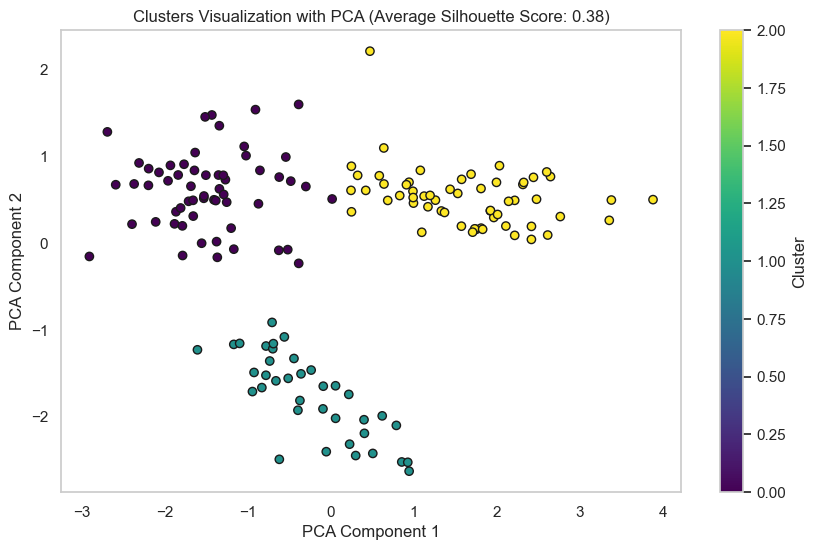

In [10]:
# Predecir los clusters en el conjunto completo
pipeline_clustering.fit(X)  # Ajustar al conjunto completo para la predicción
clusters = pipeline_clustering.predict(X)

# Añadir etiquetas de cluster al dataset original
data['Cluster'] = clusters

# Visualizar los clusters con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='k')
plt.title(f'Clusters Visualization with PCA (Average Silhouette Score: {average_silhouette_score:.2f})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.grid()
plt.show()


In [11]:
# Preparar datos para el modelo predictivo
X_features = data.drop(columns=['Cluster'])
y_labels = data['Cluster']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=42)


In [12]:
# Crear el pipeline con transformaciones y modelo
pipeline_model = Pipeline(steps=[
    ('polynomial_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('logistic_regression', LogisticRegression(max_iter=1000))
])

# Configurar GridSearchCV para ajuste de hiperparámetros
param_grid = {
    'logistic_regression__C': [0.01, 0.1, 1, 10, 100],
    'logistic_regression__solver': ['liblinear', 'saga']
}
grid_search = GridSearchCV(pipeline_model, param_grid, cv=5, scoring='accuracy')

# Ajustar el modelo a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Mejor parámetros y puntuación
best_params = grid_search.best_params_
best_score = grid_search.best_score_


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The ma

In [13]:
# Evaluar el modelo en el conjunto de prueba
y_pred = grid_search.predict(X_test)

# Reporte de clasificación
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

best_params, best_score, report, conf_matrix, average_silhouette_score


({'logistic_regression__C': 10, 'logistic_regression__solver': 'liblinear'},
 1.0,
 '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00        12\n           1       0.80      1.00      0.89         4\n           2       1.00      0.93      0.97        15\n\n    accuracy                           0.97        31\n   macro avg       0.93      0.98      0.95        31\nweighted avg       0.97      0.97      0.97        31\n',
 array([[12,  0,  0],
        [ 0,  4,  0],
        [ 0,  1, 14]]),
 0.38315948043168746)

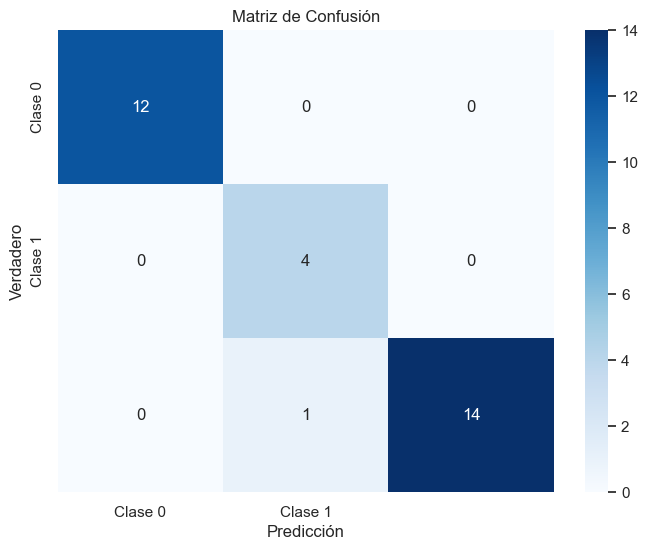

In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.ylabel('Verdadero')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()